In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patheffects as path_effects

from scipy.stats import gaussian_kde
from scipy.stats import spearmanr
from scipy.stats import expon
from statsmodels.nonparametric.kde import KDEUnivariate
from IPython.display import HTML

import os
import re
import datetime as dt
import numpy as np
import pandas as pd
import imp
bt = imp.load_source('baltic', '/Users/evogytis/Documents/BLAB_baltic/baltic.py')

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.datetime.strftime(dt.datetime.strptime(x,start),end)

def hpd(data, level):
    """
    Return highest posterior density interval from a list,
    given the percent posterior density interval required.
    """
    d = list(data)
    d.sort()

    nData = len(data)
    nIn = int(round(level * nData))
    if nIn < 2 :
        return None
    #raise RuntimeError("Not enough data. N data: %s"%(len(data)))
 
    i = 0
    r = d[i+nIn-1] - d[i]
    for k in range(len(d) - (nIn - 1)) :
        rk = d[k+nIn-1] - d[k]
        if rk < r :
            r = rk
            i = k

    assert 0 <= i <= i+nIn-1 < len(d)
 
    return (d[i], d[i+nIn-1])

subtree_root='/Users/evogytis/Documents/MERS_2.0/clean/analyses/beast/coal/'
tree12=bt.loadNexus(subtree_root+'MERS_274_sCoal.combinedTyped.mcc.tree')
tree12.root.traits['type']='reservoir'
order=[k.name for k in tree12.traverse_tree()]

seqs={}
path_to_alignment='/Users/evogytis/Documents/MERS_2.0/clean/data/alignments/MERS_CoV_274.fasta'
human_seqs=[]
for line in open(path_to_alignment,'r'):
    if '>' in line:
        name=line.strip('\n')[1:]
        if 'human' in name:
            human_seqs.append(name)
    else:
        seq=line.strip('\n')
        seqs[name]=seq

# season_path='/Users/evogytis/Dropbox/DUDAS/R0_clusters/data/posterior_introduction_probability_months.csv'
season_path='/Users/evogytis/Dropbox/DUDAS/R0_clusters/data/posterior_betas_months.csv'
for line in open(season_path,'r'):
    l=line.strip('\n').split(',')
    l=[w.strip('"') for w in l]

#     if l[0]=='V1':
    if l[0]=='beta_January':
        header={x:i for i,x in enumerate(l)}
        seasons={x:[] for x in l}
    else:
        for x in header.keys():
            seasons[x].append(np.exp(float(l[header[x]])))
        
print 'N human seqs: %d'%(len(human_seqs))

path='<iframe style="border: 0; width: 400px; height: 406px;" src="https://bandcamp.com/EmbeddedPlayer/album=3896566224/size=large/bgcol=333333/linkcol=ffffff/artwork=small/transparent=true/" seamless><a href="http://xtrvgnz.bandcamp.com/album/priepuoliai">Priepuoliai by Extravaganza</a></iframe>'

print 'Done!'
HTML(path)

N human seqs: 174
Done!


In [2]:
cluster_count=0
cluster_sizes=[]
for k in tree12.Objects:
    if k.parent.traits.has_key('type') and k.parent.traits['type']!=k.traits['type']:
        cluster_count+=1
        stree=tree12.subtree(k,traitName='type')
        
        if stree:
            
            leaves=stree.root.leaves
            out=open('/Users/evogytis/Documents/MERS_2.0/clean/data/alignments/trait_clades/MERS_%sCluster%02d_size%d.fna'%(k.traits['type'],cluster_count,len(leaves)),'w')
            
            for s in leaves:
                n=tree12.tipMap[s]
                print>>out,'>%s\n%s'%(n,seqs[n])
            cluster_sizes.append(len(leaves))
            out.close()

print cluster_sizes
print 'Done!'

[100, 7, 2, 1, 1, 1, 1, 1, 19, 1, 1, 3, 1, 29, 1, 1, 1, 1, 3, 1, 1, 1, 6, 18, 1, 1, 1, 1, 1, 2, 2, 3, 5, 2, 1, 1, 4, 1, 1, 15, 1, 4, 13, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]
Done!


In [3]:
from dendropy.calculate.popgenstat import nucleotide_diversity as pi
from dendropy.datamodel.charmatrixmodel import DnaCharacterMatrix as DNAaln
root='/Users/evogytis/Documents/MERS_2.0/clean/data/alignments/trait_clades/'

clade_pi={}
for filename in os.listdir(root):
    if "Cluster" in filename and filename.endswith('.fna'):
        print filename
        cerberus=re.match('MERS\_([a-z]+)Cluster([0-9]+)_size([0-9]+)\.fna',filename)
        t=cerberus.group(1)
        clustID=cerberus.group(2)
        size=cerberus.group(3)
        
        aln={}
        for line in open(root+filename,'r'):
            if '>' in line:
                name=line.strip('\n')[1:]
            else:
                aln[name]=line.strip('\n').replace('N','-') ## Biopython counts Ns as a nucleotide difference
        
        if len(aln)>1:
            clade_pi['%s_%s_%s'%(t,clustID,size)]=pi(DNAaln.from_dict(aln),ignore_uncertain=True)
        else:
            clade_pi['%s_%s_%s'%(t,clustID,size)]=0.0
        
print 'Done!'

MERS_cCluster01_size100.fna
MERS_hCluster02_size7.fna
MERS_hCluster03_size2.fna
MERS_hCluster04_size1.fna
MERS_hCluster05_size1.fna
MERS_hCluster06_size1.fna
MERS_hCluster07_size1.fna
MERS_hCluster08_size1.fna
MERS_hCluster09_size19.fna
MERS_hCluster10_size1.fna
MERS_hCluster11_size1.fna
MERS_hCluster12_size3.fna
MERS_hCluster13_size1.fna
MERS_hCluster14_size29.fna
MERS_hCluster15_size1.fna
MERS_hCluster16_size1.fna
MERS_hCluster17_size1.fna
MERS_hCluster18_size1.fna
MERS_hCluster19_size3.fna
MERS_hCluster20_size1.fna
MERS_hCluster21_size1.fna
MERS_hCluster22_size1.fna
MERS_hCluster23_size6.fna
MERS_hCluster24_size18.fna
MERS_hCluster25_size1.fna
MERS_hCluster26_size1.fna
MERS_hCluster27_size1.fna
MERS_hCluster28_size1.fna
MERS_hCluster29_size1.fna
MERS_hCluster30_size2.fna
MERS_hCluster31_size2.fna
MERS_hCluster32_size3.fna
MERS_hCluster33_size5.fna
MERS_hCluster34_size2.fna
MERS_hCluster35_size1.fna
MERS_hCluster36_size1.fna
MERS_hCluster37_size4.fna
MERS_hCluster38_size1.fna
MERS_hC

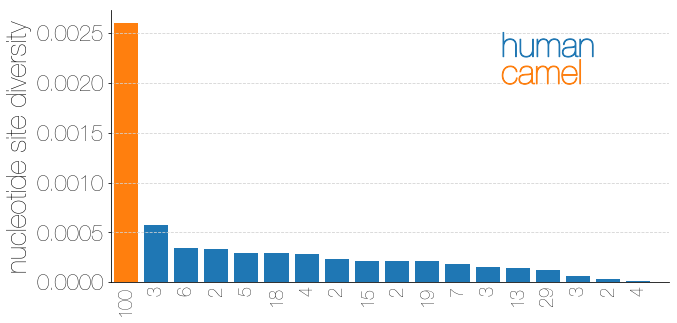

In [4]:
fig,ax = plt.subplots(figsize=(10,5),facecolor='w')

cmap=mpl.cm.Vega10
types=['h','c']

for t in range(len(types)):
    
    f='human'
    if types[t]=='c':
        f='camel'
    effects=[path_effects.Stroke(linewidth=4, foreground='white'),
             path_effects.Stroke(linewidth=1, foreground=cmap(t))] ## black text, white outline
    ax.text(0.7,0.83-t*0.1,'%s'%(f),path_effects=effects,size=34,transform=ax.transAxes)

sorted_clades=sorted([x for x in clade_pi.keys() if clade_pi[x]>0.0],key=lambda x:-clade_pi[x])
for c,clade in enumerate(sorted_clades):
    
    ax.bar(c,clade_pi[clade],facecolor=cmap(types.index(clade.split('_')[0])))

ax.set_xticks(range(len(sorted_clades)))
ax.set_xticklabels([c.split('_')[2] for c in sorted_clades],rotation=90)
ax.tick_params(axis='x',size=0,labelsize=18)
ax.set_xlim(-0.5,len(sorted_clades))
ax.set_ylabel('nucleotide site diversity',size=28)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.grid(axis='y',ls='--',color='lightgrey',zorder=0)
# ax.set_yscale('log')
plt.show()

In [5]:
scounter=0
cls=[]

jump_dates=[]

introsize=[]
clustID=0
clusterComposition={}

for s in sorted([q for q in tree12.Objects[1:] if q.traits['type']!=q.parent.traits['type']],key=lambda r:-r.absoluteTime):
    #print w.traits['type'],w.parent.traits['type']
    subtree=tree12.traverse_tree(s,include_all=True)
    clustID+=1
    clusterComposition['cluster%02d'%(clustID)]=[w.numName for w in subtree if w.branchType=='leaf'] 
    cls.append(len(tree12.traverse_tree(s)))
    jump_dates.append(s.absoluteTime)

intros={}
intro_path='/Users/evogytis/Documents/MERS_2.0/clean/analyses/beast/coal/MERS_274_sCoal.combined.intros'
for line in open(intro_path,'r'):
    l=line.strip('\n').split('\t')
    if 'state' in line:
        header=l
        indices={x:i for i,x in enumerate(header) if x!='state'}
        if len(intros)==0:
            intros={x:[] for x in header if x!='state'}
    else:
        for i in sorted(indices.keys()):
            if len(l)==len(header):
                if l[indices[i]]!='nan':
                    f=float(l[indices[i]])
#                         intros[i].append(f-int(f))
                    intros[i].append(f)

print [len(x) for x in intros.values()]

[33841, 35007, 35007, 34979, 34743, 34996, 34166, 34024, 28839, 35007, 35007, 28214, 35007, 34274, 31985, 31952, 35007, 35007, 35007, 35007, 34775, 34536, 35007, 32247, 26794, 35007, 33882, 21349, 34400, 34983, 34999, 34978, 23757, 35007, 34058, 34938, 27103, 19539, 29248, 34481, 23324, 34826, 35007, 34918, 34950, 35007, 35007, 35007, 31934, 34422, 35007, 35007, 17854]


beta_January
beta_February
beta_March
beta_April
beta_May
beta_June
beta_July
beta_August
beta_September
beta_October
beta_November
beta_December


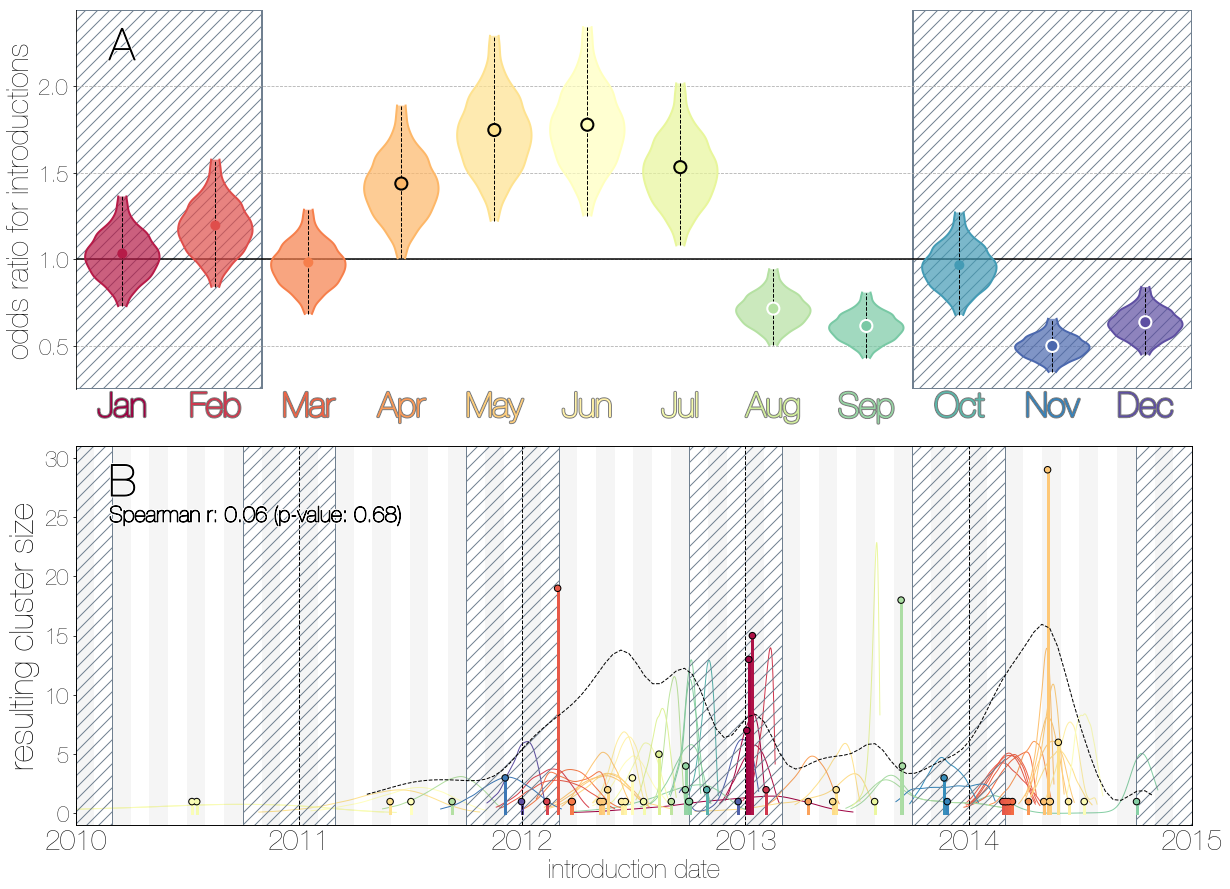

In [6]:
fig = plt.figure(figsize=(20,15),facecolor='w')
gs = gridspec.GridSpec(2, 1,height_ratios=[1,1],hspace=0.15,wspace=0.0)

ax = plt.subplot(gs[1]) ## lower plot
ax2=ax.twinx()

period=jump_dates

s=60
cmap=mpl.cm.Spectral
norm=mpl.colors.Normalize(2012,2015)
for outbreak_date,outbreak_size in zip(jump_dates,cls):
    yr=int(outbreak_date)
    x=outbreak_date
    
ax2.tick_params(axis='y',size=0)
ax2.set_yticklabels([])

for i in intros.keys():    
    kde=gaussian_kde(intros[i])
    hpdLo,hpdUp=hpd(intros[i],0.95)
    x_grid=np.linspace(hpdLo,hpdUp,100)
    y_grid=kde.evaluate(x_grid)
    mu=np.median(intros[i])
    
    #print np.mean(intros[i]),hpdUp-hpdLo,hpdLo,hpdUp
    ax.plot(x_grid,y_grid,color=cmap(mu-int(mu)),lw=1,alpha=1.0,zorder=0)
    
    ax.plot([mu,mu],[0.0,len(clusterComposition[i])],color=cmap(mu-int(mu)),lw=3,zorder=1)
    ax.scatter(mu,len(clusterComposition[i]),facecolor=cmap(mu-int(mu)),edgecolor='none',zorder=3,s=30)
    ax.scatter(mu,len(clusterComposition[i]),facecolor='k',edgecolor='none',zorder=2,s=30*1.9)

    

effects=[path_effects.Stroke(linewidth=3, foreground='w'),
                 path_effects.Stroke(linewidth=1, foreground='k')]
sr,pval=spearmanr([(np.median(intros[i]),len(clusterComposition[i])) for i in sorted(intros)])
ax.text(0.03,0.8,'Spearman r: %.2f (p-value: %.2f)'%(sr,pval),transform=ax.transAxes,path_effects=effects)
ax.text(0.03,0.95,'B',size=44,va='top',ha='left',transform=ax.transAxes,path_effects=effects)

overall=[item for sublist in intros.values() for item in sublist]
kde=gaussian_kde(overall)
hpdLo,hpdUp=hpd(overall,0.95)
x_grid=np.linspace(hpdLo,hpdUp,100)
ax.plot(x_grid,kde.evaluate(x_grid)*25,color='k',lw=1,alpha=1,ls='--')

ax.set_ylabel('resulting cluster size',size=34)
ax.set_xlabel('introduction date',size=26)
every=1
xDates=['%04d-%02d-01'%(y,m) for y in range(2010,2015) for m in range(1,13)]


[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]

ax.tick_params(axis='x',labelsize=28,size=0)

ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))

# [ax.axvspan(bt.decimalDate('%d-10-01'%(t)),bt.decimalDate('%d-03-01'%(t+1)),facecolor='slategrey',edgecolor='none',lw=2,alpha=0.3) for t in range(2009,2015)]
[ax.add_patch(plt.Rectangle((bt.decimalDate('%d-10-01'%(t)),-1),bt.decimalDate('%d-03-01'%(t+1))-bt.decimalDate('%d-10-01'%(t)),32,facecolor='none',edgecolor='slategrey',hatch='//',zorder=1)) for t in range(2009,2015)]

[ax.axvline(t,color='k',ls='--',lw=1) for t in range(2009,2016)]
ax.set_xlim(2010,2015)
ax.set_ylim(-1,31)

ax=plt.subplot(gs[0]) ## upper plot

cmap=mpl.cm.Spectral
norm=mpl.colors.Normalize(1,12)

for mon in sorted(seasons.keys(),key=lambda w:bt.decimalDate(w.split('_')[1][:3],'%b')):
    print mon
    hl,hu=hpd(seasons[mon],0.95)
    
    x=int(convertDate(mon.split('_')[1][:3],'%b','%m'))+0.5
    if hl>1.0: ## lower HPD greater than 1.0
        ax.scatter(x,np.mean(seasons[mon]),s=200,facecolor='k',edgecolor='none',zorder=10)
    elif hu<1.0: ## upper HPD lower than 1.0
        ax.scatter(x,np.mean(seasons[mon]),s=200,facecolor='w',edgecolor='none',zorder=10)
    
    fc=cmap(norm(x))    
    kde=gaussian_kde(seasons[mon])
    x_grid=np.linspace(hl,hu,101)
    y_grid=kde.evaluate(x_grid)
    y_grid=y_grid/y_grid.max()
    y_grid=y_grid*0.4
    ax.fill_betweenx(x_grid,[x+y for y in y_grid],[x-y for y in y_grid],facecolor=fc,edgecolor='none',zorder=8,alpha=0.7)
    ax.plot([x+y for y in y_grid],x_grid,color=fc,lw=2,zorder=10,ls='-')
    ax.plot([x-y for y in y_grid],x_grid,color=fc,lw=2,zorder=10,ls='-')
    
    ax.plot([x,x],[hl,hu],color='k',lw=1,zorder=9,ls='--')
    ax.scatter(x,np.mean(seasons[mon]),s=100,facecolor=fc,edgecolor='none',zorder=11)
    
ax.axhline(1.0,ls='-',color='k')


ax.axvspan(0,3,facecolor='none',hatch='//',edgecolor='slategrey',lw=2,alpha=1)
ax.axvspan(10,13,facecolor='none',hatch='//',edgecolor='slategrey',lw=2,alpha=1)

ax.set_xticks(np.arange(1.5,13.5,1))
ax.set_xticklabels([convertDate('1900-%02d-01'%(d),'%Y-%m-%d','%b') for d in range(1,13)])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# ax.set_xlim(1,13)
ax.set_xlim(1,13)
# ax.set_ylim(-1,1)
ax.tick_params(axis='x',labelsize=34,size=0)
ax.set_ylabel('odds ratio for introductions',size=30)

ax.grid(axis='y',ls='--')

for t,tick in enumerate(ax.get_xticklabels()):
    effects=[path_effects.Stroke(linewidth=3, foreground='grey'),
                 path_effects.Stroke(linewidth=1, foreground=cmap(t/11.0))]
    tick.set_path_effects(effects)

effects=[path_effects.Stroke(linewidth=3, foreground='w'),
                 path_effects.Stroke(linewidth=1, foreground='k')]
ax.text(0.03,0.95,'A',size=44,va='top',ha='left',transform=ax.transAxes,path_effects=effects)
plt.savefig('/Users/evogytis/Documents/structured-mers/figures/mers_seasonality.png',dpi=300,bbox_inches='tight')
plt.show()

In [7]:
yearly_path='/Users/evogytis/Dropbox/DUDAS/R0_clusters/data/discretised_introductions_2010-2014.csv'

yr=2010
mon=1
yearly_data={}
for line in open(yearly_path,'r'):
    l=line.strip('\n').split(',')
    if l[0]!='"V1"':
        if yearly_data.has_key(yr):
            yearly_data[yr][mon]=map(float,l)
        else:
            yearly_data[yr]={mon:map(float,l)}
        mon+=1
        if mon==13:
            mon=1
            yr+=1
            
print yearly_data.keys()

[2010, 2011, 2012, 2013, 2014]


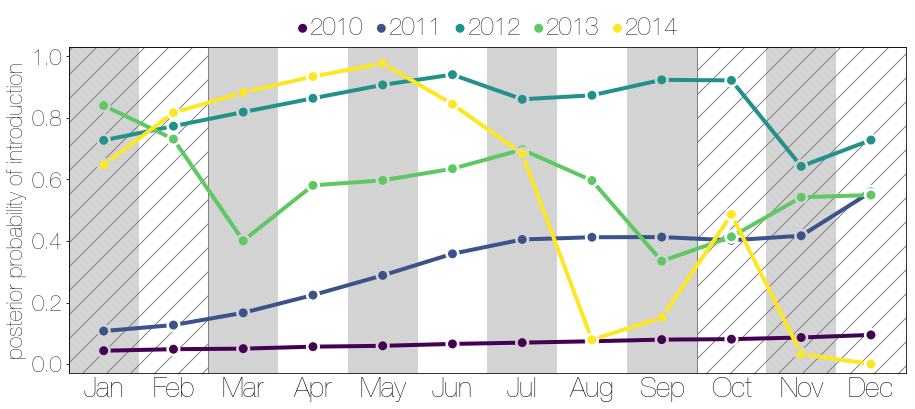

In [10]:
fig,ax = plt.subplots(figsize=(15,6),facecolor='w')

norm=mpl.colors.Normalize(min(yearly_data.keys()),max(yearly_data.keys()))

for yr in yearly_data.keys():
    mons=sorted(yearly_data[yr].keys())
    mus=[np.mean(yearly_data[yr][x]) for x in mons]
    #hpds=[hpd(yearly_data[yr][x],0.95) for x in mons]
    #hpdLos=[x[0] for x in hpds]
    #hpdHis=[x[1] for x in hpds]
    
    c=mpl.cm.viridis(norm(yr))
    
    ax.scatter(mons,mus,s=80,facecolor=c,edgecolor='none',zorder=yr+1005,label=yr)
    
    
    ax.scatter(mons,mus,s=200,facecolor=['w' if m%2==0 else 'lightgrey' for m in mons],edgecolor='none',zorder=yr+1004)
    #ax.plot(mons,mus,color='w',lw=9,zorder=yr+1001)
    ax.plot(mons,mus,color=c,lw=4,zorder=yr+1002)
    #ax.fill_between(mons,hpdLos,hpdHis,facecolor=c,alpha=0.1)

ax.add_patch(plt.Rectangle((0.5,-0.03),2,1.06,facecolor='none',edgecolor='grey',hatch='/',zorder=1))
ax.add_patch(plt.Rectangle((9.5,-0.03),3,1.06,facecolor='none',edgecolor='grey',hatch='/',zorder=1))

ax.tick_params(axis='x',labelsize=28,size=0)
ax.legend(bbox_to_anchor=(0.5, 0.96),ncol=len(yearly_data),frameon=False,fontsize=24,columnspacing=0.5,labelspacing=0.5,handlelength=0.5,handletextpad=0.05)
ax.set_ylabel('posterior probability of introduction')
ax.set_xticks(range(1,13))
[ax.axvspan(x-0.5,x+0.5,facecolor='lightgrey',edgecolor='none',zorder=0) for x in range(1,13,2)]
ax.set_xticklabels([convertDate('1900-%02d-01'%(m),'%Y-%m-%d','%b') for m in range(1,13)])
ax.set_xlim(0.5,12.5)
ax.set_ylim(-0.03,1.03)
plt.savefig('/Users/evogytis/Documents/structured-mers/figures/mers_yearly.png',dpi=300,bbox_inches='tight')
plt.show()

In [9]:
data={}
log_path='/Users/evogytis/Documents/MERS_2.0/clean/analyses/beast/'
fnames=['coal_prior10/MERS_274_sCoal_prior10.combined.log','coal/MERS_274_sCoal.combined.log']

for fname in fnames:
    for line in open(log_path+fname,'r'):
        l=line.strip('\n').split('\t')
        if l[0]=='Sample':
            header={x:i for i,x in enumerate(l[:-1])}
            #print header
            data[fname]={x:[] for x in l[:-1]}
        else:
            for x in data[fname].keys():
                data[fname][x].append(float(l[header[x]]))

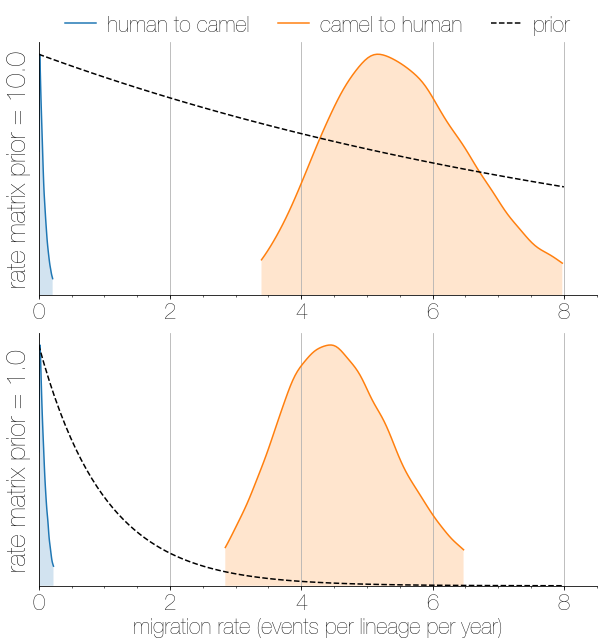

In [11]:
fig = plt.figure(figsize=(10,10),facecolor='w')
gs = gridspec.GridSpec(2, 1,height_ratios=[1,1],hspace=0.15,wspace=0.05)

ul=plt.subplot(gs[0])
ur=plt.subplot(gs[1],sharex=ul)
# ll=plt.subplot(gs[2],sharex=ul)
# lr=plt.subplot(gs[3],sharex=ur)

gss=[ul,ur]

for f,fname in enumerate(data.keys()):
#     for s,stat in enumerate(['Tree.count_c_to_h','Tree.count_h_to_c']):
    ax = gss[f] ## lower plot
    
    for s,stat in enumerate(['migModel.rateMatrix_c_h','migModel.rateMatrix_h_c']):
        
#         jump_counts=map(int,data[fname][stat]) ## due to a bug in beast2 this is actually the human to camel jumps
        
#         ucounts=set(jump_counts)
#         xs=range(hpdLo,hpdUp)
#         ys=[jump_counts.count(x)/float(len(jump_counts)) for x in xs]

#         xso=range(hpdUp,max(ucounts))
#         xso+=range(min(ucounts),hpdLo)
#         yso=[jump_counts.count(x)/float(len(jump_counts)) for x in xso]

#         print fname,stat,np.median(jump_counts),hpdLo,hpdUp
#         ax.bar(xs,ys)
#         ax.bar(xso,yso,facecolor='indianred')
#         ax.set_xlim(0.0,max(ucounts))

        jump_counts=map(float,data[fname][stat])
        hpdLo,hpdUp=hpd(jump_counts,0.95)
        kde=gaussian_kde(jump_counts)
        x_grid=np.linspace(hpdLo,hpdUp,100)
        y_grid=kde.evaluate(x_grid)
        y_grid=y_grid/y_grid.max()
        
        if stat=='migModel.rateMatrix_c_h':
            c=mpl.cm.Vega10(0)
        else:
            c=mpl.cm.Vega10(1)

            
        if s==0:
            label='human to camel'
        else:
            label='camel to human'
            
        ax.fill_between(x_grid,y_grid,alpha=0.2,facecolor=c)
        ax.plot(x_grid,y_grid,color=c,label=label)

        if 'prior' in fname and s==0:
            ax.set_ylabel('rate matrix prior = 10.0',size=26)
        elif s==0:
            ax.set_ylabel('rate matrix prior = 1.0',size=26)

    prior_x=np.linspace(0.0,8.0,100)
    
    if 'prior' in fname:
        prior_y=expon.pdf(prior_x,scale=10.0)
    else:
        prior_y=expon.pdf(prior_x,scale=1.0)

#         ax.plot(prior_x,prior_y/prior_y.max()*max(ys),color='k',ls='--')
    ax.plot(prior_x,prior_y/prior_y.max()*max(y_grid),color='k',ls='--',label='prior')
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.set_ylim(bottom=0.0)
    

    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    
    ax.grid(axis='x')
    ax.tick_params(axis='y',size=0)
    ax.set_yticklabels([])
    
    ax.set_xlim(0,8.5)
        
gss[0].legend(bbox_to_anchor=(0.0, 0.95, 0.95, .102),loc=3,ncol=3,columnspacing=1.0,handletextpad=0.2,frameon=False,numpoints=10)
# gss[0].legend(bbox_to_anchor=(0.02,0.95),ncol=3,frameon=False)
ax.set_xlabel('migration rate (events per lineage per year)')
plt.savefig('/Users/evogytis/Documents/structured-mers/figures/mers_prior.png',dpi=300,bbox_inches='tight')
plt.show()

55.9236724084 56.0 48.0 63.0
[48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0]
[ 0.01250112  0.02025838  0.03034281  0.04451472  0.06372885  0.08416624
  0.10287317  0.11427037  0.11456873  0.10740818  0.09246054  0.07441
  0.0547185   0.03944267  0.026315    0.0180207 ]
0.999999985099


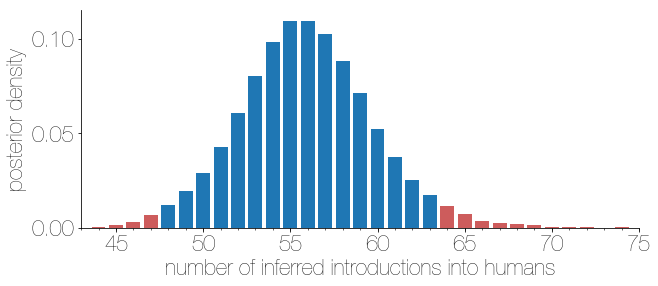

In [12]:
fig,ax = plt.subplots(figsize=(10,4),facecolor='w')

d=data['coal/MERS_274_sCoal.combined.log']['Tree.count_h_to_c']
mcmcCounter=len(d)
hpdLo,hpdHi=hpd(d,0.95)
print np.mean(d),np.median(d),hpdLo,hpdHi
freqs={x:d.count(x) for x in set(d) if hpdLo<=x<=hpdHi}
out={x:d.count(x) for x in set(d) if x<hpdLo or hpdHi<x}
f=sorted(freqs.keys())
o=sorted(out.keys())

ax.bar(f,[freqs[x]/float(mcmcCounter) for x in f])
ax.bar(o,[out[x]/float(mcmcCounter) for x in o],color='indianred')

fs=np.array([freqs[x]/float(mcmcCounter) for x in f],dtype=np.float32)
print f
print fs/sum(fs)
print sum(fs/sum(fs))

ax.set_xticks(range(0,int(max(d))),minor=True)
ax.set_xlim(43,75)

ax.set_ylabel('posterior density')
ax.set_xlabel('number of inferred introductions into humans')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

3.97100579884 3.0 0.0 12.0
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
[ 0.17736521  0.15734442  0.13476905  0.11311451  0.09603446  0.07978613
  0.0635675   0.04996287  0.04164562  0.02979355  0.02489232  0.01850587
  0.01321848]
1.00000000093


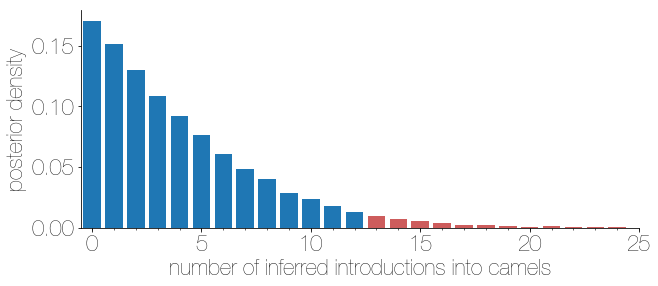

In [13]:
fig,ax = plt.subplots(figsize=(10,4),facecolor='w')

d=data['coal/MERS_274_sCoal.combined.log']['Tree.count_c_to_h']
mcmcCounter=len(d)
hpdLo,hpdHi=hpd(d,0.95)
print np.mean(d),np.median(d),hpdLo,hpdHi
freqs={x:d.count(x) for x in set(d) if hpdLo<=x<=hpdHi}
out={x:d.count(x) for x in set(d) if x<hpdLo or hpdHi<x}
f=sorted(freqs.keys())
o=sorted(out.keys())

ax.bar(f,[freqs[x]/float(mcmcCounter) for x in f])
ax.bar(o,[out[x]/float(mcmcCounter) for x in o],color='indianred')

fs=np.array([freqs[x]/float(mcmcCounter) for x in f],dtype=np.float32)
print f
print fs/sum(fs)
print sum(fs/sum(fs))

ax.set_xticks(range(0,int(max(d))),minor=True)
ax.set_xlim(-0.5,25)

ax.set_ylabel('posterior density')
ax.set_xlabel('number of inferred introductions into camels')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

coal_prior10/MERS_274_sCoal_prior10.combined.log migModel.popSize_c 3.66 2.78 4.58
coal_prior10/MERS_274_sCoal_prior10.combined.log migModel.popSize_h 0.22 0.13 0.31
coal/MERS_274_sCoal.combined.log migModel.popSize_c 3.49 2.71 4.38
coal/MERS_274_sCoal.combined.log migModel.popSize_h 0.24 0.14 0.34


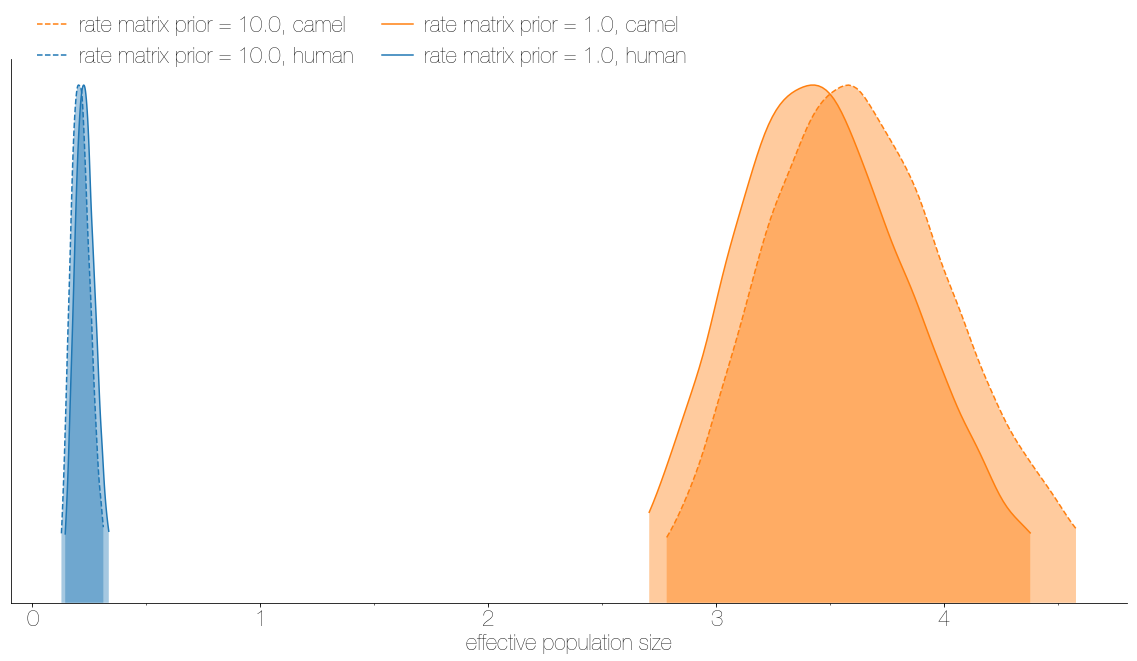

In [14]:

fig = plt.figure(figsize=(20,10),facecolor='w')
gs = gridspec.GridSpec(1, 1,hspace=0.25,wspace=0.1)

ul=plt.subplot(gs[0])
# ur=plt.subplot(gs[1],sharex=ul)
# ll=plt.subplot(gs[2],sharex=ul)
# lr=plt.subplot(gs[3],sharex=ur)

gss=[ul,ur]

for f,fname in enumerate(data.keys()):
#     for s,stat in enumerate(['Tree.count_c_to_h','Tree.count_h_to_c']):
    
    al=0.4
    
    for s,stat in enumerate(['migModel.popSize_c','migModel.popSize_h']):
#         ax = gss[s] ## lower plot
        ax=ul
        jump_counts=map(float,data[fname][stat])
        hpdLo,hpdUp=hpd(jump_counts,0.95)
        kde=gaussian_kde(jump_counts)
        x_grid=np.linspace(hpdLo,hpdUp,100)
        y_grid=kde.evaluate(x_grid)
        y_grid=y_grid/y_grid.max()
        
        print fname,stat,'%.2f %.2f %.2f'%(np.mean(jump_counts),hpdLo,hpdUp)
        
        if 'prior' in fname:
            label='rate matrix prior = 10.0'
            ls='--'
        else:
            label='rate matrix prior = 1.0'
            ls='-'
        
        if stat=='migModel.popSize_h':
            c=mpl.cm.Vega10(0)
            label.replace(', camel','')
            label+=', human'
        else:
            c=mpl.cm.Vega10(1)
            label.replace(', human','')
            label+=', camel'
            
        ax.fill_between(x_grid,y_grid,alpha=al,facecolor=c)
        ax.plot(x_grid,y_grid,ls=ls,color=c,label=label)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.spines['left'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        ax.set_ylim(bottom=0.0)


        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))

        ax.grid(axis='x')
        ax.tick_params(axis='y',size=0)
        ax.set_yticklabels([])
    
#     ax.set_xlim(0,8.5)
        
        ax.legend(bbox_to_anchor=(0.0, 0.95, 0.95, .102),loc=3,ncol=2,columnspacing=1.0,handletextpad=0.2,frameon=False,numpoints=10)
# gss[0].legend(bbox_to_anchor=(0.02,0.95),ncol=3,frameon=False)
ax.set_xlabel('effective population size')
#ax.legend()
plt.show()